<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/Register_Image_Stack.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/Register_Image_Stack.ipynb)
    
part of

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [5]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.8.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q --upgrade
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
# ------------------------------
print('done')

done


**In Google Colab: Please restart runtime Ctrl+M**

### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../..')
%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools     # File input/ output library
import pyTEMlib.eels_tools
import pyTEMlib.eds_tools


if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2023_1_20'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2023.8.1


## Open File

### Choose Mode of  File Selection


The FileWidget will use display the name of a Nion File like in NionSwift.

Select a main dataset and any additional data like reference data and such.

In [2]:
fileWidget = pyTEMlib.file_tools.FileWidget()

### Load File

If you did not choose the file widget a File Dialog window will open in the next code cell.

Otherewise just select a File in the widget above

These datasets are stored in the pyNSID data format (extension: hf5) automatically.

All results can be stored in that file.

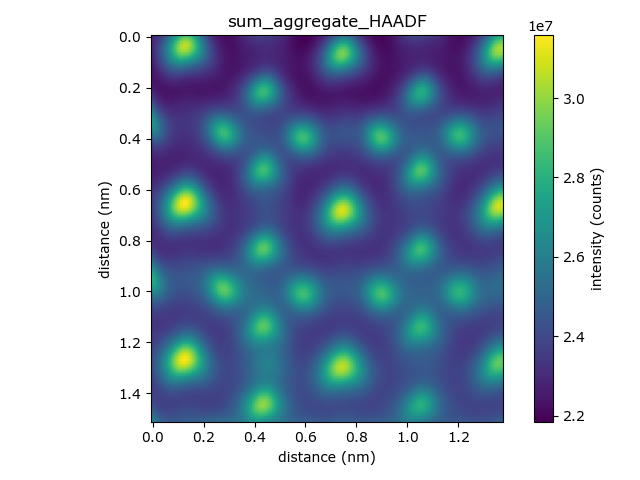

In [3]:
datasets = fileWidget.datasets
dataset = datasets['HAADF']
dataset.data_type = 'image'
if dataset.data_type.name != 'IMAGE':
    print('We really would need an image here')

view = dataset.plot()

## Spectrum Image
Select the HAADF image reference

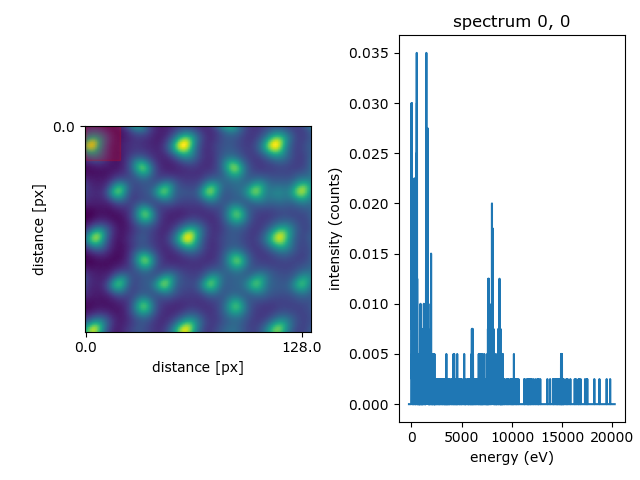

In [4]:
datasets = fileWidget.datasets
dataset = datasets['HAADF']
dataset.data_type = 'image'
view = datasets['spectrum_image'].plot()
view.axes[0].imshow(datasets['HAADF'])
datasets['spectrum_image'].view.set_bin(20)

In [6]:
chooser = pyTEMlib.file_tools.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('HAADF: sum_aggregate_HAADF', 'spectrum_image: SuperXG22_new'…

['Channel_004', 'Channel_005', 'Channel_006', 'Channel_007']


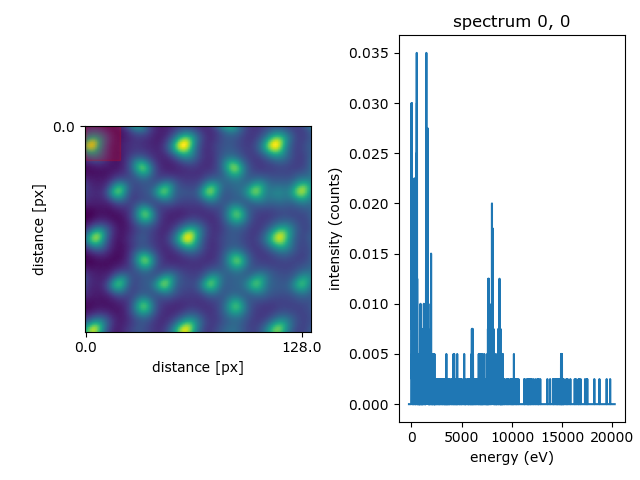

In [51]:
eds_keys = []
for key in datasets.keys():
  if 'SuperX' in datasets[key].title:
      eds_keys.append(key)
print(eds_keys)
dataset = datasets[eds_keys[0]] 
dataset += datasets[eds_keys[1]]+datasets[eds_keys[2]]+datasets[eds_keys[3]]

view = dataset.plot()
view.axes[0].imshow(chooser.dataset.sum(axis=0))
dataset.view.set_bin(20)

In [8]:
spectrum =  datasets['spectrum_image'].sum(axis=[0, 1])
spectrum = datasets['spectrum_image'].get_dataset()
spectrum.data_type = 'spectrum'
spectrum.title = datasets['spectrum_image'].title[:-1]
view = spectrum.plot()

AttributeError: 'SpectralImageVisualizer' object has no attribute 'get_dataset'

In [104]:
plt.close('all')

In [12]:
minor_peaks = pyTEMlib.eds_tools.detect_peaks(spectrum)
elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)
elements

['C', 'O', 'Mn', 'Cu', 'Ge', 'Al', 'Kr', 'Y', 'Rh', 'Gd', 'Fe', 'Ho', 'Lu']

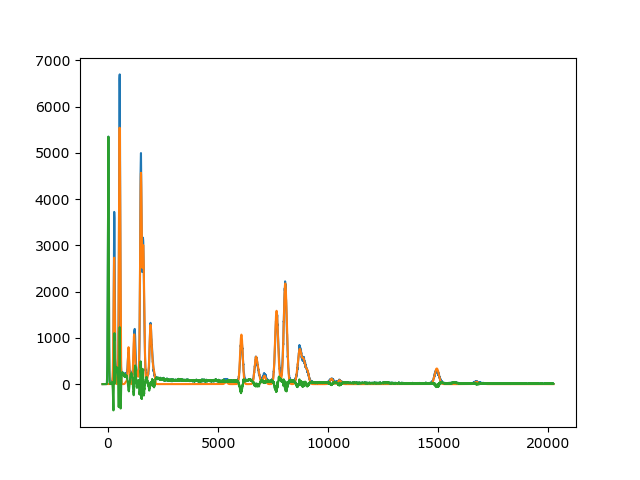

In [127]:
elements = ['C', 'O', 'Cu',  'Al',  'Y', 'Gd',  'Lu']
peaks, p = pyTEMlib.eds_tools.fit_model(spectrum, elements)

model = np.zeros(len(spectrum))
for i in range(len(p)):
    model += peaks[i]*p[i]
    
plt.figure()
plt.plot(spectrum.energy_scale, spectrum)

plt.plot(spectrum.energy_scale,model)
plt.plot(spectrum.energy_scale,spectrum-model)

In [4]:
pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements)

for element in spectrum.metadata['EDS']['lines']:
    for key in spectrum.metadata['EDS']['lines'][element]:
        if 'family' in key:
            print(f" {element}, {key}, {spectrum.metadata['EDS']['lines'][element][key]['height']/spectrum.metadata['EDS']['lines'][element][key]['ionization_x_section']/spectrum.metadata['EDS']['lines'][element][key]['yield']:.0f}")
            #print(element, key, spectrum.metadata['EDS']['lines'][element][key]['height'], spectrum.metadata['EDS']['lines'][element][key]['ionization_x_section'], spectrum.metadata['EDS']['lines'][element][key]['yield'])
                        

NameError: name 'pyTEMlib' is not defined

In [130]:
(2800+1007+758)/7581, (3761+697+1936)/10100, 4*1.4/1

(0.602163302994328, 0.6330693069306931, 5.6)

In [81]:
22332/10100

2.2110891089108913

In [25]:
pyTEMlib.eds_tools.get_eds_cross_sections(64)

{'L': 22.9734286637647, 'M': 1996.0782838592195}

In [79]:
3/5, 12/5

(0.6, 2.4)

In [114]:
pyTEMlib.eds_tools.get_eds_cross_sections(71)

{'L': 42.18061572940657, 'M': 2965.039298940282}

15334.559999999998 17033.399999999998
17038.399999999998


1.6177347987502473

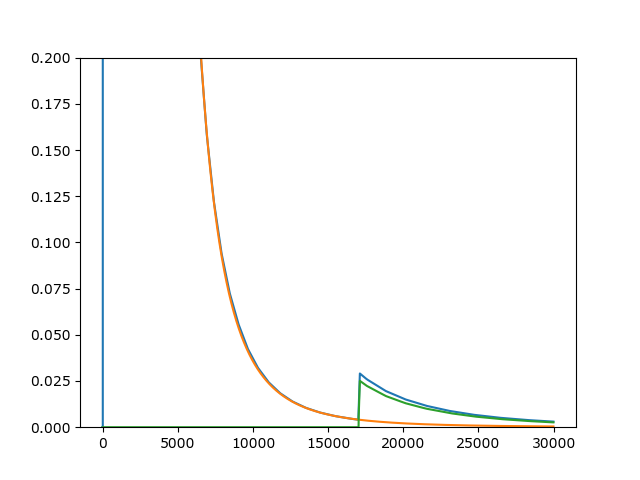

In [12]:
z = 39
energy_scale = np.arange(10, 30000)
Xsection = pyTEMlib.eels_tools.xsec_xrpa(energy_scale, 200, z, 1000.)
edge_info =  pyTEMlib.eels_tools.get_x_sections(z)
start_bgd = edge_info['K1']['onset'] * 0.9
end_bgd = edge_info['K1']['onset']  - 5
if start_bgd > end_bgd:
    start_bgd = end_bgd-100
print( start_bgd, end_bgd)
# K_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)#
bgd, _  = pyTEMlib.eels_tools.power_law_background(Xsection, energy_scale, [start_bgd,  end_bgd], verbose=False)
print(edge_info['K1']['onset'])
plt.figure()
plt.plot(Xsection)

start_sum = np.searchsorted(energy_scale,edge_info['K1']['onset'])
plt.plot(bgd)
plt.ylim(0,.2)
#plt.xlim(start_bgd,start_bgd+400)
xs = (Xsection - bgd)
xs[xs<0] = 0


xs[:start_sum] =0

plt.plot(xs)

xs[start_sum: start_sum+100].sum()


In [ ]:
plt.close('all')
plt.figure()
plt.plot(Xsection)

In [ ]:
l

179


ValueError: x and y must have same first dimension, but have shapes (179,) and (175,)

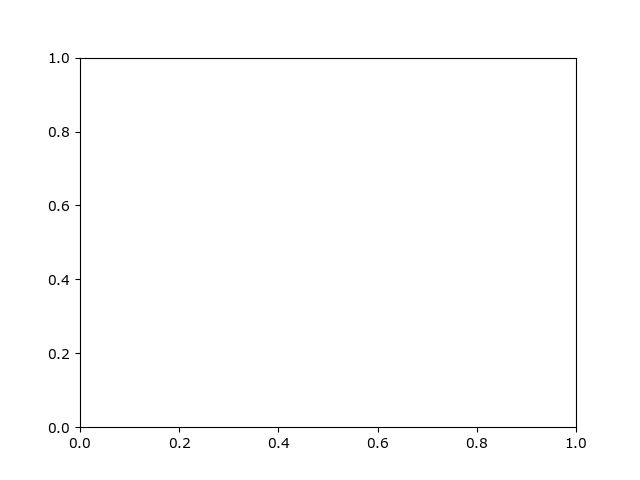

In [157]:
xs = pyTEMlib.xrpa_x_sections.x_sections['39']
print(len(xs['ene']))
plt.figure()

plt.plot(xs['ene'], xs['dat'])

1980.0 2075.0
2080.0


0.22976153063497584

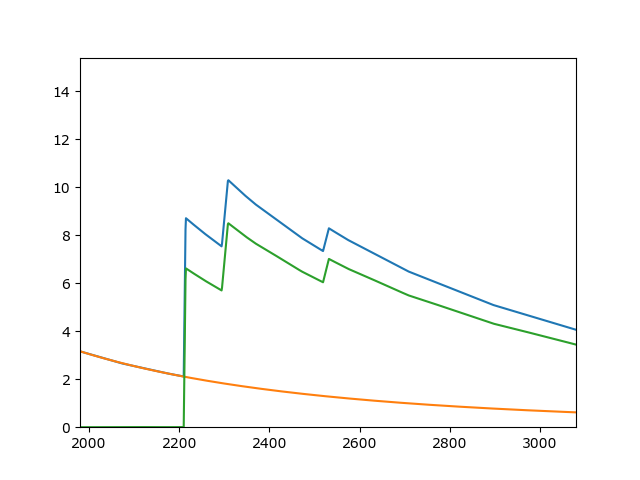

In [163]:
energy_scale = np.arange(10, 20000)
Xsection = pyTEMlib.eels_tools.xsec_xrpa(energy_scale, 200, 39, 1000.)
edge_info =  pyTEMlib.eels_tools.get_x_sections(39)
start_bgd = edge_info['L3']['onset'] -100
end_bgd = edge_info['L3']['onset']  - 5
print( start_bgd, end_bgd)
# K_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)#
bgd, _  = pyTEMlib.eels_tools.power_law_background(Xsection, energy_scale, [start_bgd,  end_bgd], verbose=False)
print(edge_info['L3']['onset'])
plt.figure()
plt.plot(Xsection)

plt.plot(bgd)
plt.ylim(0,15.4)
plt.xlim(edge_info['L3']['onset'] -100,edge_info['L3']['onset'] + 1000)
xs = (Xsection - bgd)
xs[xs<0] = 0

start_sum = np.searchsorted(energy_scale,edge_info['L3']['onset'])
xs[:start_sum] =0

plt.plot(xs)

xs[start_sum: start_sum+100].sum()

In [46]:
import scipy 
import sidpy
from pyTEMlib import eds_tools

spectrum.metadata['EDS'] = {'energy_resolution': 128}
def detect_peaks(dataset):
    if not isinstance(dataset, sidpy.Dataset):
        raise TypeError('Needs an sidpy dataset')
    if not dataset.data_type.name == 'SPECTRUM':
        raise TypeError('Need a spectrum')
    
    resolution = dataset.metadata['EDS']['energy_resolution']
    start = np.searchsorted(spectrum.energy_scale, 125)
    ## we use half the width of the resolution for smearing
    width = int(np.ceil(125/(spectrum.energy_scale[1]-spectrum.energy_scale[0])/2)+1)
    new_spectrum =  scipy.signal.savgol_filter(spectrum[start:], width, 2) ## we use half the width of the resolution for smearing
    new_energy_scale = spectrum.energy_scale[start:]
    prominence = 10
    minor_peaks, _  = scipy.signal.find_peaks(new_spectrum, prominence=prominence)
    
    while len(minor_peaks) > 30:
        prominence+=10
        minor_peaks, _  = scipy.signal.find_peaks(new_spectrum, prominence=prominence)
    return np.array(minor_peaks)+start


In [11]:
minor_peaks = pyTEMlib.eds_tools.detect_peaks(spectrum)
elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)
out_tags = pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements)

In [16]:
plt.close('all')


['C', 'O', 'Mn', 'Cu', 'Ge', 'Al', 'Kr', 'Y', 'Rh', 'Gd', 'Fe', 'Ho', 'Lu']

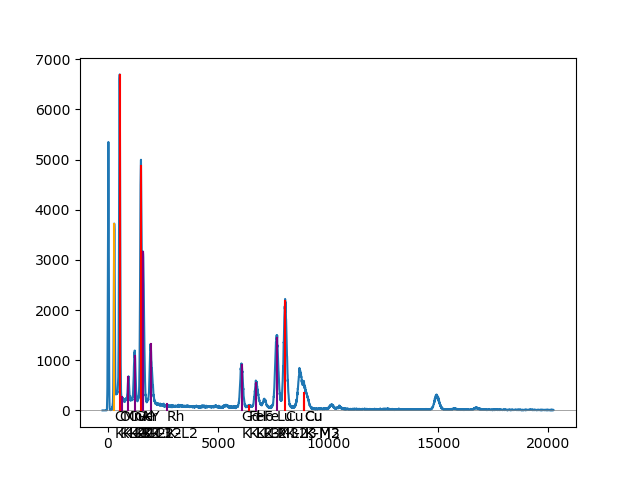

In [93]:
from pyTEMlib.xrpa_x_sections import x_sections
new_energy_scale = spectrum.energy_scale
new_spectrum = np.array(spectrum)
plt.figure()
#plt.plot(energy_scale1,spectrum2, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')

plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);

out_tags = {}
elements = []
number_of_elements = 0
for peak in minor_peaks:
    found = False
    for element in range(3,82):
        if 'lines' in x_sections[str(element)]:

            if 'K-L3' in x_sections[str(element)]['lines']:
                if abs(x_sections[str(element)]['lines']['K-L3']['position']- new_energy_scale[peak]) <10:
                    found = True
                    out_tags[number_of_elements] = {}
                    out_tags[number_of_elements]['element'] = x_sections[str(element)]['name']
                    out_tags[number_of_elements]['found_lines'] = 'K-L3'
                    out_tags[number_of_elements]['lines'] = x_sections[str(element)]['lines']
                    out_tags[number_of_elements]['experimental_peak_index'] = peak
                    out_tags[number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                    number_of_elements += 1
                    if  x_sections[str(element)]['name'] not in elements:
                        elements.append( x_sections[str(element)]['name'])
                    plt.plot([x_sections[str(element)]['lines']['K-L3']['position'], x_sections[str(element)]['lines']['K-L3']['position']], [0,new_spectrum[peak]], color = 'red')
                    plt.text(new_energy_scale[peak],0, x_sections[str(element)]['name']+'\nK-L3', verticalalignment='top')
                    for line in x_sections[str(element)]['lines']:
                        if 'K' in line:
                            if abs(x_sections[str(element)]['lines'][line]['position']-x_sections[str(element)]['lines']['K-L3']['position'])> 20:
                                if x_sections[str(element)]['lines'][line]['weight']>0.07:
                                    #print(element, x_sections[str(element)]['lines'][line],new_spectrum[peak]*x_sections[str(element)]['lines'][line]['weight'])
                                    plt.plot([x_sections[str(element)]['lines'][line]['position'],x_sections[str(element)]['lines'][line]['position']], [0,new_spectrum[peak]*x_sections[str(element)]['lines'][line]['weight']], color = 'red')
                                    plt.text(x_sections[str(element)]['lines'][line]['position'],0, x_sections[str(element)]['name']+'\n'+line, verticalalignment='top')
            if not found:
              if 'K-L2' in x_sections[str(element)]['lines']:
                if abs(x_sections[str(element)]['lines']['K-L2']['position']- new_energy_scale[peak]) <10:
                    found = True
                    plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'orange')
                    plt.text(new_energy_scale[peak],0, x_sections[str(element)]['name']+'\nK-L2', verticalalignment='top')
                    out_tags[number_of_elements] = {}
                    out_tags[number_of_elements]['element'] = x_sections[str(element)]['name']
                    out_tags[number_of_elements]['found_lines'] = 'K-L2'
                    out_tags[number_of_elements]['lines'] = x_sections[str(element)]['lines']
                    out_tags[number_of_elements]['experimental_peak_index'] = peak
                    out_tags[number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]

                    number_of_elements += 1
                    if  x_sections[str(element)]['name'] not in elements:
                        elements.append( x_sections[str(element)]['name'])
            if not found:
              if 'L3-M5' in x_sections[str(element)]['lines']:
                  if abs(x_sections[str(element)]['lines']['L3-M5']['position']- new_energy_scale[peak]) <30:
                      plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'purple')
                      plt.text(new_energy_scale[peak],0, x_sections[str(element)]['name']+'\nK-L2', verticalalignment='top')

                      #plt.scatter( new_energy_scale[peak], new_spectrum[peak], color = 'blue')
                      out_tags[number_of_elements] = {}
                      out_tags[number_of_elements]['element'] = x_sections[str(element)]['name']
                      out_tags[number_of_elements]['found_lines'] = 'L3-M5'
                      out_tags[number_of_elements]['lines'] = x_sections[str(element)]['lines']
                      out_tags[number_of_elements]['experimental_peak_index'] = peak
                      out_tags[number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                      number_of_elements += 1
                      if  x_sections[str(element)]['name'] not in elements:
                          elements.append( x_sections[str(element)]['name'])
#for element in out_tags:
#    print(out_tags[element]['element'],out_tags[element]['found_lines'])
elements



In [64]:
from pyTEMlib.xrpa_x_sections import x_sections
plt.close('all')

def find_elements(spectrum, minor_peaks):
    if not isinstance(spectrum, sidpy.Dataset):
        raise TypeError(' Need a sidpy dataset')
    energy_scale = spectrum.energy_scale
    elements = []
    for peak in minor_peaks:
        found = False
        for element in range(3,82):
            if 'lines' in x_sections[str(element)]:
                if 'K-L3' in x_sections[str(element)]['lines']:
                    if abs(x_sections[str(element)]['lines']['K-L3']['position']- energy_scale[peak]) <10:
                        found = True
                        if  x_sections[str(element)]['name'] not in elements:
                            elements.append( x_sections[str(element)]['name'])
                if not found:
                    if 'K-L2' in x_sections[str(element)]['lines']:
                        if abs(x_sections[str(element)]['lines']['K-L2']['position']- energy_scale[peak]) <10:
                            found = True
                            if  x_sections[str(element)]['name'] not in elements:
                                elements.append( x_sections[str(element)]['name'])
                if not found:
                    if 'L3-M5' in x_sections[str(element)]['lines']:
                        if abs(x_sections[str(element)]['lines']['L3-M5']['position']- energy_scale[peak]) <30:
                              if  x_sections[str(element)]['name'] not in elements:
                                    elements.append( x_sections[str(element)]['name'])
    return elements
elements = eds_tools.find_elements(spectrum, minor_peaks)


NameError: name 'elements_list' is not defined

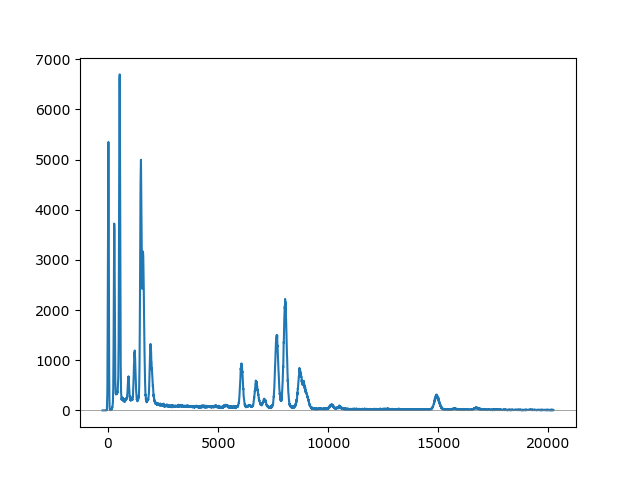

In [94]:
from dask.array.routines import searchsorted
elements = ['C', 'O', 'Cu',  'Al',  'Y', 'Gd',  'Lu']

plt.close('all')
plt.figure()
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
out_tags = {}
plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);

for element in elements:
    atomic_number = elements_list.index(element)
    out_tags[element] ={'Z': atomic_number}

    for key, line in x_sections[str(atomic_number)]['lines'].items():

        if line['weight'] > 0.01 and line['position'] < 3e4:
            if key[0] == 'K':
                if 'K-family' not in out_tags[element]:
                     out_tags[element]['K-family'] = {}

                if 'K-L3' in x_sections[str(atomic_number)]['lines']:
                  height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines']['K-L3']['position'] )]
                else:
                  height = 1000
                out_tags[element]['K-family']['height'] = height
                out_tags[element]['K-family'][key]=line
                if key == 'K-L3':
                    plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'blue', label=element+': K')
                else:
                    plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'blue')

                plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')
            elif key[:2] in ['L2', 'L3']:
                if 'L-family' not in out_tags[element]:
                     out_tags[element]['L-family'] = {}
                if 'L3-M5' in x_sections[str(atomic_number)]['lines']:
                  height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines']['L3-M5']['position'] )]
                else:
                  height = 1000
                height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines']['L3-M5']['position'] )]
                out_tags[element]['L-family']['height'] = height
                out_tags[element]['L-family'][key]=line
                if key == 'L3-M5':
                    plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'red', label=element+': L')
                else:
                    plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'red')
                plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')
            elif key[:2] in ['M5', 'M4']:
                if 'M-family' not in out_tags[element]:
                     out_tags[element]['M-family'] = {}

                if 'M5-N7' in x_sections[str(atomic_number)]['lines']:
                  height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines']['M5-N7']['position'] )]
                else:
                  height = 1000
                out_tags[element]['M-family'][key]=line
                out_tags[element]['M-family']['height'] = height
                plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'orange')
                plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')
            else:
                if 'other' not in out_tags[element]:
                     out_tags[element]['other'] = {}
                height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines'][key]['position'] )]
                out_tags[element]['other'][key]=line
                out_tags[element]['other'][key]['height'] = height
                plt.plot([line['position'],line['position']], [0,height], color = 'orange')
                plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')

            #print(element, line['position'], key)

for key, x_lines in out_tags.items():
    if 'K-family' in x_lines:
        xs = eels.xsec_xrpa(np.arange(100)+x_sections[str(x_lines['Z'])]['K1']['onset'], 200,x_lines['Z'], 100).sum()
        x_lines['K-family']['ionization_x_section'] = xs
    if 'L-family' in x_lines:
        xs = eels.xsec_xrpa(np.arange(100)+x_sections[str(x_lines['Z'])]['L3']['onset'], 200,x_lines['Z'], 100).sum()
        x_lines['L-family']['ionization_x_section'] = xs

plt.legend()




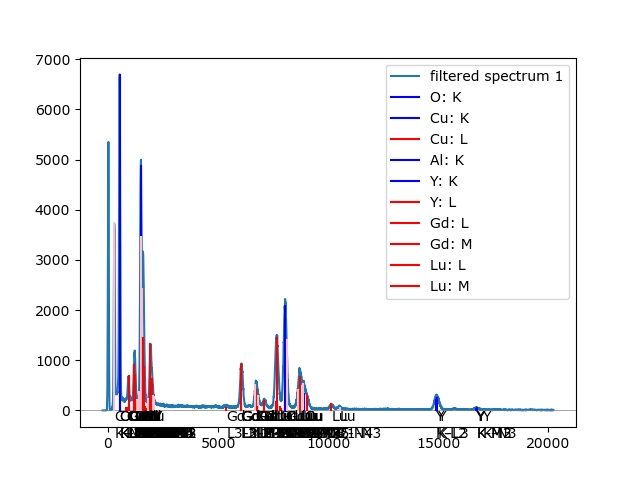

In [22]:
from dask.array.routines import searchsorted
elements = ['C', 'O', 'Cu',  'Al',  'Y', 'Gd',  'Lu']
elements_list = [' ', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na',
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V',
            'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br',
            'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag',
            'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr',
            'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
            'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi']
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
out_tags = {}
plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);
for element in elements:

    atomic_number = elements_list.index(element)
    out_tags[element] ={'Z': atomic_number}

    if 'K-L3' in x_sections[str(atomic_number)]['lines']:
        if x_sections[str(atomic_number)]['lines']['K-L3']['position'] < 3e4:
            height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines']['K-L3']['position'] )]
            out_tags[element]['K-family'] = {'height': height}

    if 'L3-M5' in x_sections[str(atomic_number)]['lines']:
        if x_sections[str(atomic_number)]['lines']['L3-M5']['position'] < 3e4:
            height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines']['L3-M5']['position'] )]
            out_tags[element]['L-family'] = {'height': height}

    if 'M5-N6' in x_sections[str(atomic_number)]['lines']:
        if x_sections[str(atomic_number)]['lines']['M5-N6']['position'] < 3e4:
            height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines']['M5-N7']['position'] )]
            out_tags[element]['M-family'] = {'height': height}

    for key, line in x_sections[str(atomic_number)]['lines'].items():
        other = True
        if line['weight'] > 0.01 and line['position'] < 3e4:
            if 'K-family' in out_tags[element]:
                if key[0] == 'K':
                    other = False
                    out_tags[element]['K-family'][key]=line
                    height = out_tags[element]['K-family']['height']
                    if key == 'K-L3':
                        plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'blue', label=element+': K')
                    else:
                        plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'blue')

                    plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')
            if 'L-family' in out_tags[element]:
                if key[:2] in ['L2', 'L3']:
                    other = False
                    height = out_tags[element]['L-family']['height']
                    out_tags[element]['L-family'][key]=line
                    if key == 'L3-M5':
                        plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'red', label=element+': L')
                    else:
                        plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'red')
                    plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')
            if 'M-family' in out_tags[element]:
                if key[:2] in ['M5', 'M4']:
                    other = False
                    height = out_tags[element]['L-family']['height']
                    if key == 'M5-N6':
                        plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'red', label=element+': M')
                    else:
                        plt.plot([line['position'],line['position']], [0,height*line['weight']], color = 'red')
                    plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')

            if other:
                if 'other' not in out_tags[element]:
                     out_tags[element]['other'] = {}
                height = new_spectrum[np.searchsorted(new_energy_scale, x_sections[str(atomic_number)]['lines'][key]['position'] )]
                out_tags[element]['other'][key]=line
                out_tags[element]['other'][key]['height'] = height
                plt.plot([line['position'],line['position']], [0,height], color = 'pink')
                plt.text(line['position'],0, x_sections[str(atomic_number)]['name']+'\n'+key, verticalalignment='top')

            #print(element, line['position'], key)

for key, x_lines in out_tags.items():
    if 'K-family' in x_lines:
        xs = eels.xsec_xrpa(np.arange(100)+x_sections[str(x_lines['Z'])]['K1']['onset'], 200,x_lines['Z'], 100).sum()
        x_lines['K-family']['ionization_x_section'] = xs
    if 'L-family' in x_lines:
        xs = eels.xsec_xrpa(np.arange(100)+x_sections[str(x_lines['Z'])]['L3']['onset'], 200,x_lines['Z'], 100).sum()
        x_lines['L-family']['ionization_x_section'] = xs
    if 'M-family' in x_lines:
        xs = eels.xsec_xrpa(np.arange(100)+x_sections[str(x_lines['Z'])]['M5']['onset'], 200,x_lines['Z'], 100).sum()
        x_lines['M-family']['ionization_x_section'] = xs

plt.legend()




In [9]:
out_tags = eds_tools.get_x_ray_lines(spectrum, elements)

NameError: name 'eds_tools' is not defined

In [17]:
dataset

sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<add, shape=(512, 512, 4096), dtype=uint16, chunksize=(512, 512, 4096), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  distance (nm) of size (512,)
y:  distance (nm) of size (512,)
energy_scale:  energy (eV) of size (4096,)
 with metadata: ['experiment', 'filename', 'EDS']

In [ ]:
out_tags

{'C': {'Z': 6,
  'other': {'K-L2': {'weight': 0.5,
    'position': 277.40000000000003,
    'height': 2793.1938697318583}}},
 'O': {'Z': 8,
  'K-family': {'height': 5370.074329502025,
   'K-L3': {'weight': 1.0, 'position': 524.9},
   'K-L2': {'weight': 0.5, 'position': 524.9},
   'ionization_x_section': 3417.8149023226697,
   'peaks': array([8.52800511e-35, 7.49081241e-34, 6.40231734e-33, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00])}},
 'Cu': {'Z': 29,
  'K-family': {'height': 2129.142528735676,
   'K-L3': {'weight': 1.0, 'position': 8047.799999999999},
   'K-L2': {'weight': 0.653, 'position': 8027.9},
   'K-M3': {'weight': 0.155, 'position': 8905.3},
   'K-M2': {'weight': 0.0864, 'position': 8905.3},
   'ionization_x_section': 4.150436926486625,
   'peaks': array([0., 0., 0., ..., 0., 0., 0.])},
  'L-family': {'height': 614.8996168582502,
   'L3-M5': {'weight': 1.0, 'position': 929.5},
   'L3-M4': {'weight': 0.114, 'position': 929.5},
   'L3-M1': {'weight': 0.0654, '

1
O 293.6665461983017 0.9999999999999999
Cu 33.23398705032408 0.9999999999999999
Al 175.94717492607663 0.9999999999999998
Y 2.8451636428028864 0.9999999999999999
8
9
12
13
14
15
16
17
20
21
22
23
24
[3.72300000e+03 2.93666546e+02 3.32339871e+01 1.45142503e+04
 1.75947175e+02 2.84516364e+00 4.30769901e+04 2.68000000e+02
 2.94000000e+02 5.19134757e+04 0.00000000e+00 2.79000000e+02
 5.08000000e+02 1.41000000e+03 2.00000000e+02 2.42400000e+03
 3.60000000e+02 9.36255031e+04 0.00000000e+00 5.25000000e+02
 4.16000000e+02 5.60000000e+01 3.45800000e+03 2.33000000e+02]
0 197598547.18495005 53075.086539067976 3723.0
1 197598840.85149628 0.9999999999999999 293.6665461983017
[3.72300000e+03 2.93666546e+02 3.32339871e+01 1.45142503e+04
 1.75947175e+02 2.84516364e+00 4.30769901e+04 2.68000000e+02
 2.94000000e+02 5.19134757e+04 0.00000000e+00 2.79000000e+02
 5.08000000e+02 1.41000000e+03 2.00000000e+02 2.42400000e+03
 3.60000000e+02 9.36255031e+04 0.00000000e+00 5.25000000e+02
 4.16000000e+02 5.600000

C:\Users\gduscher\AppData\Local\Temp\ipykernel_7808\64398364.py:49: RuntimeWarning: invalid value encountered in divide
  peaks.append(model/model.sum())


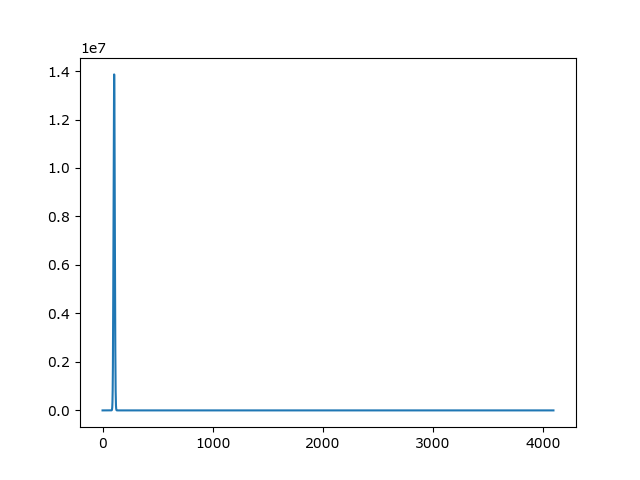

In [50]:
def getFWHM(E, E_ref, FWHM_ref):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)

def gaussian(enrgy_scale, mu, FWHM):
    sig = FWHM/2/np.sqrt(2*np.log(2))
    return np.exp(-np.power(enrgy_scale - mu, 2.) / (2 * np.power(sig, 2.)))

def get_peak(E, energy_scale):
    E_ref = 5895.0
    FWHM_ref = 136 #eV
    FWHM  = getFWHM(E, E_ref, FWHM_ref)
    gaus = gaussian(energy_scale, E, FWHM)

    return gaus /gaus.max()


def model(tags, spectrum):

    energy_scale = spectrum.energy_scale
    p = []
    peaks = []
    for element, lines in tags.items():
        if 'K-family' in lines:
            model = np.zeros(len(energy_scale))
            for line, info in lines['K-family'].items():
                if line[0] == 'K':
                    model += get_peak(info['position'], energy_scale)*info['weight']
            p.append(lines['K-family']['height']/model.sum())
            peaks.append(model/model.sum())
            lines['K-family']['peaks']=model
            print(element, lines['K-family']['height']/model.sum(), peaks[-1].sum())

        if 'L-family' in lines:
            model = np.zeros(len(energy_scale))
            for line, info in lines['L-family'].items():
                if line[0] == 'L':
                    model += get_peak(info['position'], energy_scale)*info['weight']
            p.append(lines['L-family']['height']*model.sum())
            peaks.append(model/model.sum())
            lines['L-family']['peaks'] = model
            
        if 'M-family' in lines:
            model = np.zeros(len(energy_scale))
            for line, info in lines['M-family'].items():
                if line[0] == 'M':
                    model += get_peak(info['position'], energy_scale)*info['weight']
            lines['M-family']['peaks']=model
            p.append(lines['M-family']['height']*model.sum())
            peaks.append(model/model.sum())
            
        if 'other' in lines:
            for line, info in lines['other'].items():
                info['peak'] =  get_peak(info['position'], energy_scale)*info['height']
                peaks.append(info['peak'])
                p.append(info['height'])
                print(len(p))
    return np.array(peaks), np.array(p)

peaks, p = model(out_tags, spectrum)
print(p)
model_spectrum = np.zeros(len(spectrum.energy_scale))
for i in range(len(p[1:3])):
    model_spectrum = model_spectrum + peaks[i] *p[i]
    print(i, model_spectrum.sum(), peaks[i].sum(), p[i])
print(p)
plt.figure()
plt.plot(model_spectrum)
#plt.plot(np.array(spectrum))


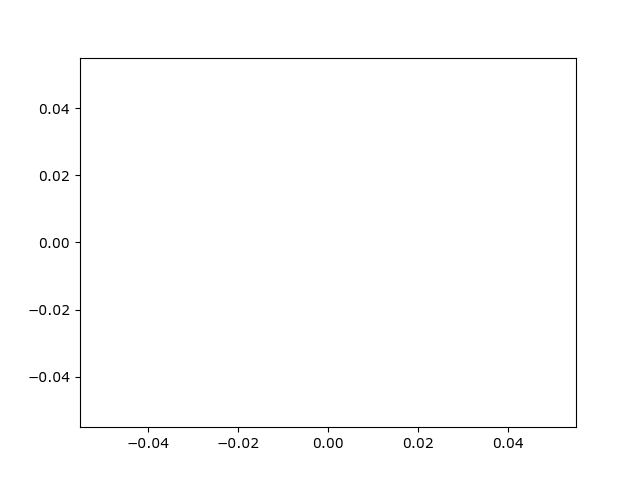

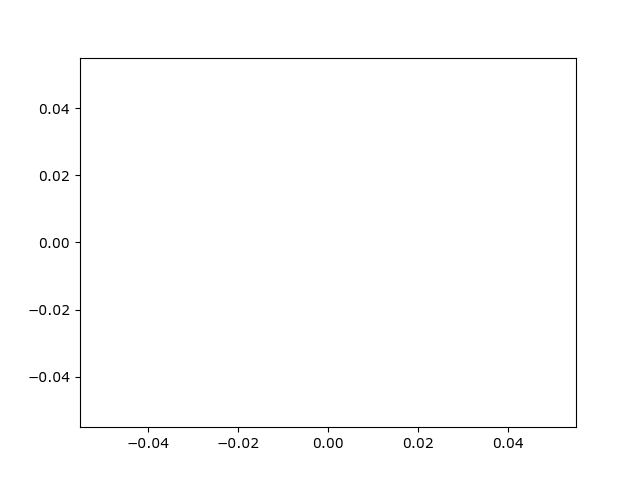

In [35]:
plt.figure()
plt.plot(model_spectrum)
#plt.plot(np.array(spectrum))

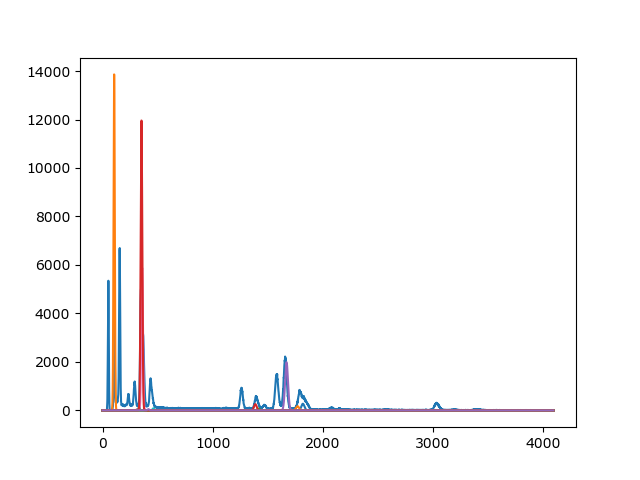

In [31]:

plt.figure()
plt.plot(new_spectrum)
for i in range(len(p)):
        plt.plot(peaks[i]*p[i]/1000)



In [67]:
plt.close('all')

In [ ]:
out_tags['O']

{'Z': 8,
 'K-family': {'height': 5370.074329502025,
  'K-L3': {'weight': 1.0, 'position': 524.9},
  'K-L2': {'weight': 0.5, 'position': 524.9},
  'ionization_x_section': 3417.8149023226697}}

### Determine Quality of Rigid Registration

First we fit a polynom of degree **polynom_degree** onto the drift of x and y separately.

The Nion STEMs are extremly stable and sub_pixel drift per image can be achieved.

A pixel of size 30pm distributed over 512 pixel (the size of many images) is obviously negletible.

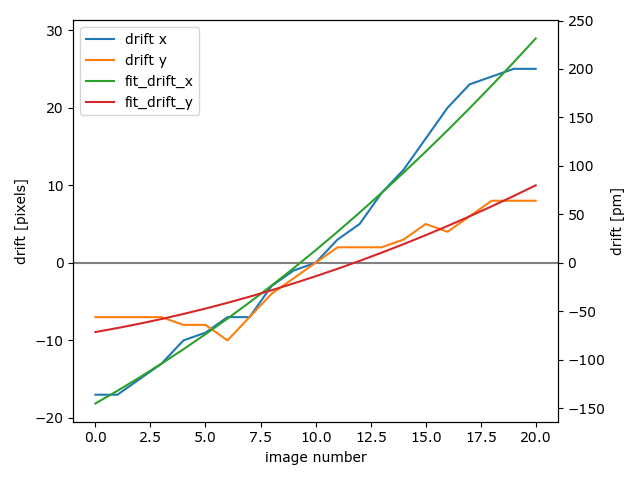

In [ ]:
scale_x = ft.get_slope(rig_reg_dataset.x.values)*1000.
drift = rig_reg_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.08


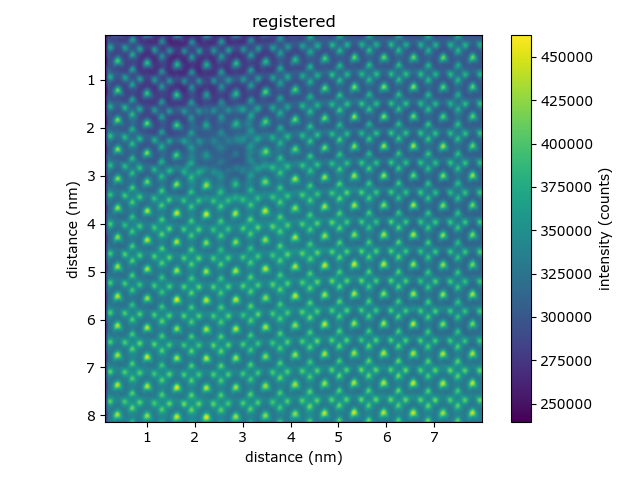

In [ ]:
image = rig_reg_dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

image.set_dimension(0,rig_reg_dataset.dim_1)
image.set_dimension(1,rig_reg_dataset.dim_2)
print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view =image.plot()


### Log Rigid Registration

We store the croped image-stack and drift-data here.

In [ ]:
datasets['Log_000'] = image.copy()


## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite:
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

In [ ]:
non_rigid_registered = it.demon_registration(rig_reg_dataset)

view = non_rigid_registered.plot()

  0%|          | 0/20 [00:00<?, ?it/s]

### Contrast
The image should have improved in contrast and signal noise ratio.

In [ ]:
image = non_rigid_registered.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'
image.set_dimension(0,non_rigid_registered.dim_1)
image.set_dimension(1,non_rigid_registered.dim_2)

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()

### Log Non-Rigid Registration

In [ ]:
datasets['Log_001'] = non_rigid_registered

A tree-like plot of the file

## Comparison of Different Dataset

A convenient function to select a dataset (for further processing, visualization or whatever)

In [ ]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'Log_001: Non-…

The selected dataset can then easily be plotted

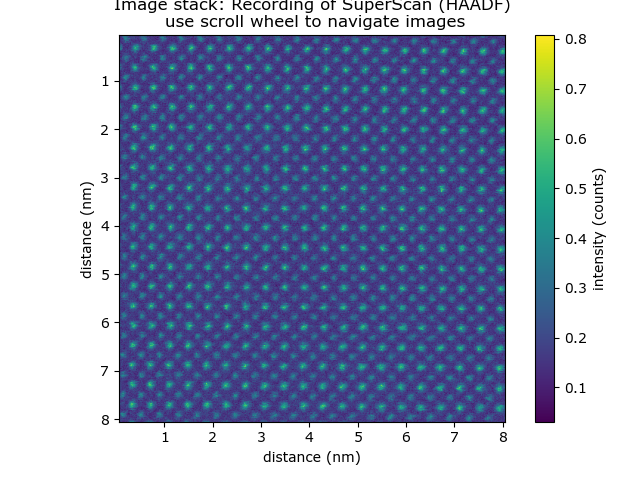

In [ ]:
view = chooser.dataset.plot()

## Find Atom Positions
### Lucy -Richardson Deconvolution

Lucy - Richardson Deconvolution removes noise and convolutes the intensity back into the atom (columns).

Here we use a slightly modified Lucy - Richardson Deconvolution which stops when converged.

Ideally the atom_size should be as large as the atoms in the image.

A good Lucy-Richardson Deconvolution should result in an image with atoms of a radius of about 2 pixels.

The number of steps to convergence should be less than 300 for a good approximation of atom_size.


In [ ]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: DCFI%28HAADF%29', 'Channel_001: HAADF', 'Log_00…

Contrast = 0.11
Deconvolution of  Non_Rigid Registration


  0%|          | 0/500 [00:00<?, ?it/s]

terminate
converged in 501 iterations

 Lucy-Richardson deconvolution converged in 501  iterations


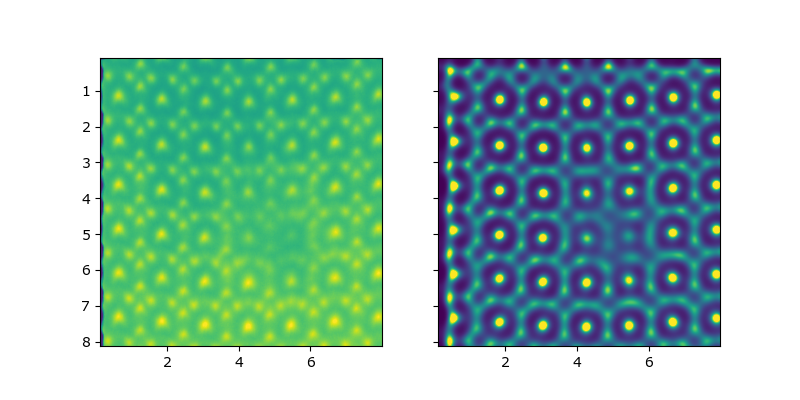

In [ ]:
# ------- Input ------
atoms_size = 0.12 # in nm
# --------------------
image = chooser.dataset

dataset = chooser.dataset
if dataset.ndim >2:
    image = dataset.sum(axis=0)
else:
    image = dataset
image.data_type = 'image'
image.title = 'registered'

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

out_tags = {}
image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 200000.}

scale_x = ft.get_slope(image.dim_0)
gauss_diameter = atoms_size/scale_x
gauss_probe = pyTEMlib.probe_tools.make_gauss(image.shape[0], image.shape[1], gauss_diameter)

print('Deconvolution of ', dataset.title)
LR_dataset = it.decon_lr(image, gauss_probe, verbose=False)

extent = LR_dataset.get_extent([0,1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image[:500,:500].T, extent = extent,vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].imshow(LR_dataset[:500,:500].T, extent = extent, vmax=np.median(np.array(LR_dataset))+3*np.std(np.array(LR_dataset)));


In [ ]:
LR_dataset.metadata = {'analysis': 'Lucy_Richardson Deconvolution',
                        'name': 'Lucy_Richardson',
                        'title': 'Lucy Richardson',
                        'notebook': __notebook__ ,
                        'notebook_version': __notebook_version__,
                        'input': dataset.title,
                        'probe_diameter': gauss_diameter,
                        'kind_of_probe': 'Gauss',
                        'probe_width': atoms_size
                        }

datasets['Log_002'] = LR_dataset

### Blob Detection

Choose threshold and atom size so that all atoms or at least all bright atoms of an unit cell are found

863


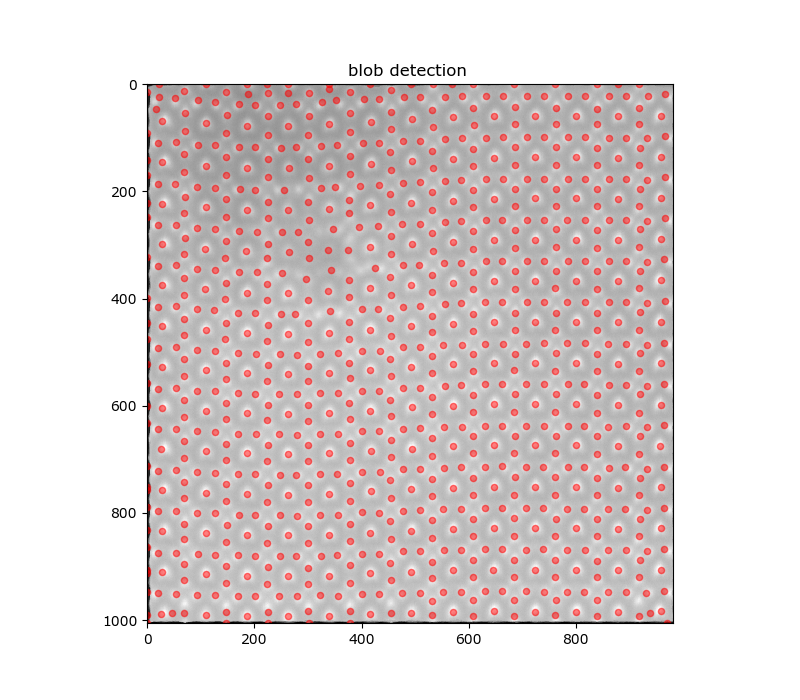

In [ ]:
# ------- Input ------
threshold = 0.03 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = 0.1 #in nm
# ----------------------
scale_x = ft.get_slope(image.dim_1)
blobs =  skimage.feature.blob_log(LR_dataset, max_sigma=atom_size/scale_x, threshold=threshold)
print(len(blobs))
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

### Determination of atom intensities

Please note that the colorbar is interactive with the selection tools

  0%|          | 0/863 [00:00<?, ?it/s]

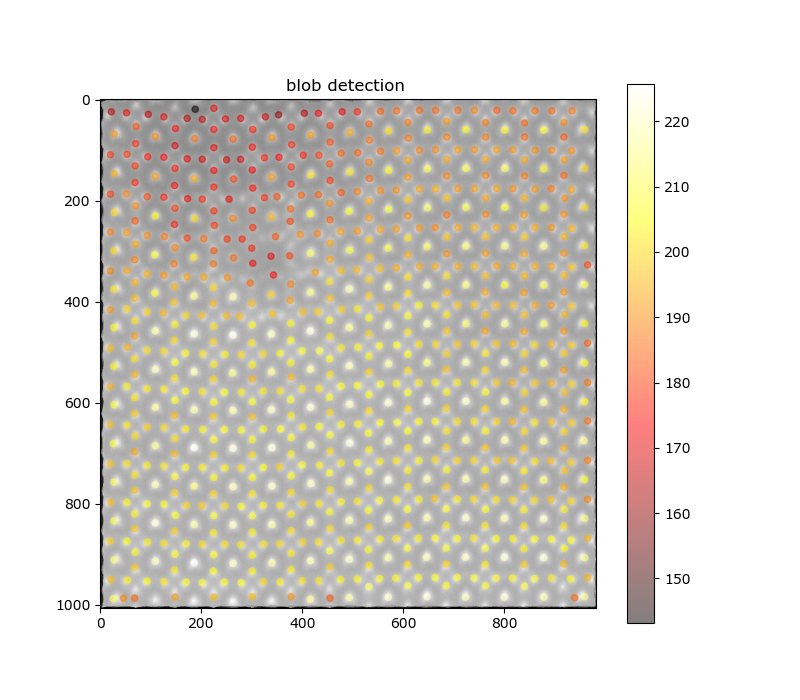

In [ ]:
from tqdm.auto import trange, tqdm
integrate = 16
new_blobs = []
integrate = int(integrate/2)
for blob in tqdm(blobs):
    blob[2] = 0.
    if (blob[:2]-integrate*2 > 0).all() and (blob[:2]-image.shape+integrate*2 <0).all():
        blob[2] = image[int(blob[0]-integrate):int(blob[0]+integrate), int(blob[1]-integrate):int(blob[1]+integrate)].sum()
        new_blobs.append(blob)

new_blobs = np.array(new_blobs)
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray')# , vmax=np.median(np.array(image))+3*np.std(np.array(image)))
sc = plt.scatter(new_blobs[:, 0], new_blobs[:, 1], c=new_blobs[:, 2], s=20, alpha = .5, cmap='hot');
plt.colorbar(sc)

### Logging the data with found atoms

In [ ]:
image.title = 'atom finding'
image.metadata['atoms']  =  {'analysis': 'Atom Positions with blob finder',
                             'notebook': __notebook__,
                             'notebook_version': __notebook_version__,
                             'atoms': blobs,
                             'atom_size': atom_size, #in nm gives the size of the atoms or resolution
                             'threshold':  threshold,
                             'pixel_size': scale_x,
                             'name': 'Atom finding',
                             'title': 'Atom finding',
                             'new_atoms': new_blobs}
datasets['Log_003'] =  image

## Save File
let's save the datasets

In [69]:
datasets={'spectrum_image': dataset,
          "HAADF": chooser.dataset.sum(axis=0)}

h5_group = ft.save_dataset(datasets, filename=dataset.metadata['filename'])

C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [70]:
print('original file ', dataset.metadata['filename'])
print('was saved to: '+ h5_group.file.filename)

original file  c:\Users\gduscher\Documents\2023-Experiments\20230802\0104 - 20230802 1757 SI HAADF 5.8 nm.emd
was saved to: c:\Users\gduscher\Documents\2023-Experiments\20230802\0104 - 20230802 1757 SI HAADF 5.8 nm.hf5


Please note, that the file is still open, so we need to close it.

In [71]:
h5_group.file.close()